In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
import cv2

from google.colab import drive
from PIL import Image, ImageFilter
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

In [3]:
# mount drive for loading data
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_dir = '/content/drive/MyDrive/ADL_project/'
orig_dir = root_dir + 'orig/'
resized_dir = root_dir + 'resized/'

In [5]:
# resizes images (use for quick presentation)
def resize_img(root, file):
  if not os.path.exists(resized_dir + file):
    img = Image.open(root + file)
    img.thumbnail((64,64))
    img_arr = np.asarray(img)
    Image.fromarray(img_arr).save(resized_dir + file)

# creates numpy array representation of the images
def get_arr(root, file):
  img = Image.open(root + file)
  img_arr = np.asarray(img)
  return img_arr

In [6]:
# # resize the images
# for file in np.sort(os.listdir(orig_dir)):
#   resize_img(orig_dir, file)

In [7]:
# # load images as np array
# y = []
# for file in np.sort(os.listdir(resized_dir)):
#   y.append(get_arr(resized_dir, file))

# # divide by 255 so that all values are between 0 and 1
# y = np.array(y)
# y = y/255.

In [8]:
# # use if you already have saved npy files
# X_train = np.load(root_dir + 'X_train.npy')
# y_train = np.load(root_dir + 'y_train.npy')
# X_test = np.load(root_dir + 'X_test.npy')
# y_test = np.load(root_dir + 'y_test.npy')

In [9]:
# load data and save as numpy array
y = []
for i, file in enumerate(np.sort(os.listdir(orig_dir))):
  img = Image.open(orig_dir + file)
  img_arr = np.asarray(img)
  y.append(img_arr)

  if i % 100 == 0:
    print("processing {}/{}".format(i, 1000))

y = np.array(y)
y = y / 255.

processing 0/1000
processing 100/1000
processing 200/1000
processing 300/1000
processing 400/1000
processing 500/1000
processing 600/1000
processing 700/1000
processing 800/1000
processing 900/1000


In [10]:
# sanity check
print(y[0,0,0])
print(y.shape)

[0.99215686 0.90588235 0.76078431]
(1000, 218, 178, 3)


In [11]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(y, y, test_size = 0.2)

In [12]:
# create low resolution image dataset for X_train and X_test
def get_low(img_arr_list):
  for i, img_arr in enumerate(img_arr_list):
    small = cv2.resize(img_arr, (int(img_arr.shape[1] * 1/4), int(img_arr.shape[0] * 1/4)), 
                                  interpolation = cv2.INTER_AREA)
    low_img = cv2.resize(small, (img_arr.shape[1], img_arr.shape[0]),
                          interpolation =  cv2.INTER_AREA)
    if i == 0:
      X_list = [low_img]
    else:
      X_list = np.concatenate((X_list, [low_img]), axis=0)
  return X_list

X_train = get_low(y_train)
X_test = get_low(y_test)

In [13]:
# sanity check
print(X_train.shape, y_train.shape, '\n',
      X_test.shape, y_test.shape)

(800, 218, 178, 3) (800, 218, 178, 3) 
 (200, 218, 178, 3) (200, 218, 178, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


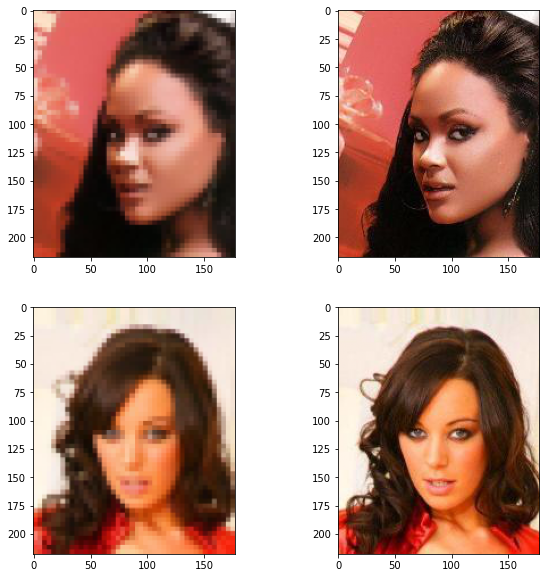

In [14]:
# plot images to check
# row 1 train set, row 2 test set
# blurred image on left, resized(original) on right

fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].imshow(X_train[0])
ax[0,1].imshow(y_train[0])
ax[1,0].imshow(X_test[0])
ax[1,1].imshow(y_test[0])

In [15]:
# save the data for later use
np.save(root_dir + 'X_train.npy', X_train)
np.save(root_dir + 'y_train.npy', y_train)
np.save(root_dir + 'X_test.npy', X_test)
np.save(root_dir + 'y_test.npy', y_test)

In [16]:
# create autoencoder model
# didn't dare exploring with tuner since it took too long, but this seemed to be the most efficient
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

# encoder
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 3, strides = 2,
                 padding = 'same', input_shape = X_train.shape[1:]))
model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1,
                 padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = 3, strides = 1,
                 padding = 'same'))

# decoder
model.add(Conv2DTranspose(filters = 16, kernel_size = 3, strides = 2,
                          padding = 'same'))
model.add(Conv2DTranspose(filters = 3, kernel_size = 3, strides = 1,
                 padding = 'same', activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 109, 89, 64)       1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 89, 32)       18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 89, 16)       4624      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 218, 178, 16)      2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 218, 178, 3)       435       
Total params: 27,635
Trainable params: 27,635
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy', metrics = ['accuracy'],
              optimizer = tf.keras.optimizers.Adam(lr=0.001))

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = 10, 
                    batch_size= 32, 
                    validation_data = (X_test, y_test))

Epoch 1/10
25/25 [==============================] - 73s 3s/step - loss: 0.6660 - accuracy: 0.6113 - val_loss: 0.5755 - val_accuracy: 0.7405
Epoch 2/10
25/25 [==============================] - 66s 3s/step - loss: 0.5305 - accuracy: 0.7408 - val_loss: 0.4945 - val_accuracy: 0.7875
Epoch 3/10
25/25 [==============================] - 65s 3s/step - loss: 0.4853 - accuracy: 0.7918 - val_loss: 0.4908 - val_accuracy: 0.8042
Epoch 4/10
25/25 [==============================] - 65s 3s/step - loss: 0.4878 - accuracy: 0.8258 - val_loss: 0.4895 - val_accuracy: 0.8394
Epoch 5/10
25/25 [==============================] - 66s 3s/step - loss: 0.4858 - accuracy: 0.8338 - val_loss: 0.4887 - val_accuracy: 0.8386
Epoch 6/10
25/25 [==============================] - 66s 3s/step - loss: 0.4829 - accuracy: 0.8427 - val_loss: 0.4883 - val_accuracy: 0.8373
Epoch 7/10
25/25 [==============================] - 66s 3s/step - loss: 0.4799 - accuracy: 0.8326 - val_loss: 0.4879 - val_accuracy: 0.8429
Epoch 8/10
25/25 [==

In [19]:
# print the validation accuracy
print('val_accuracy:', round(history.history['val_accuracy'][-1],2))

val_accuracy: 0.87


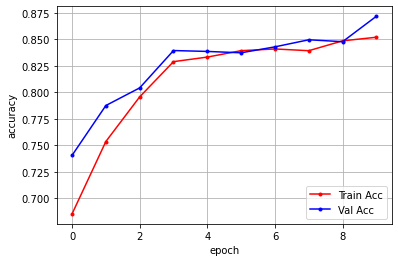

In [20]:
# plot accuracy and val_accuracy
plt.plot(history.history['accuracy'], marker='.', c='red', label="Train Acc")
plt.plot(history.history['val_accuracy'], marker='.', c='blue', label="Val Acc")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [21]:
# save the trained model
model.save('/content/ADL_project_model.h5')

In [22]:
!ls -lha

total 392K
drwxr-xr-x 1 root root 4.0K May 10 18:47 .
drwxr-xr-x 1 root root 4.0K May 10 18:27 ..
-rw-r--r-- 1 root root 370K May 10 18:47 ADL_project_model.h5
drwxr-xr-x 4 root root 4.0K May  6 13:43 .config
drwx------ 6 root root 4.0K May 10 18:29 drive
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data


In [23]:
# download the model
from google.colab import files
files.download('/content/ADL_project_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# # load model
# model = tf.keras.models.load_model('/content/ADL_project_model.h5')

In [37]:
# get predicted images
preds = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


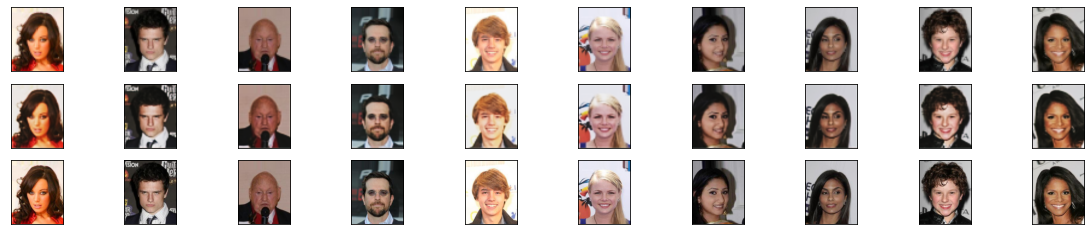

In [38]:
# compare results
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(20,4))
for images, row in zip([X_test[:10], preds[:10], y_test[:10]], ax):
    for img, ax in zip(images, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

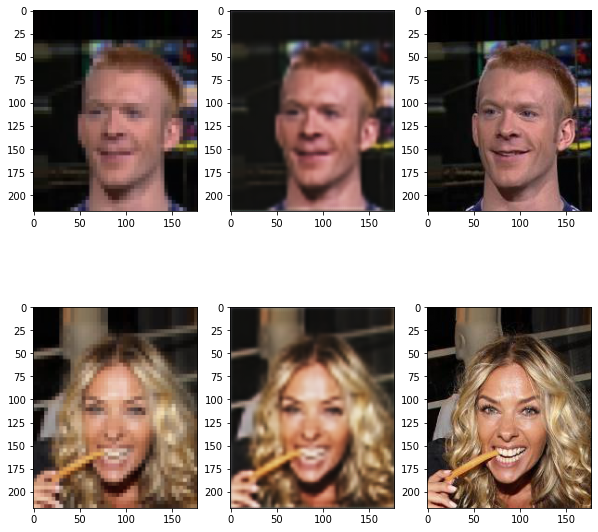

In [45]:
# get a closer comparison
rand_num1 = random.randint(0,200)
rand_num2 = random.randint(0,200)

fig, ax = plt.subplots(2,3, figsize=(10, 10))
ax[0,0].imshow(X_test[rand_num1])
ax[0,1].imshow(preds[rand_num1])
ax[0,2].imshow(y_test[rand_num1])
ax[1,0].imshow(X_test[rand_num2])
ax[1,1].imshow(preds[rand_num2])
ax[1,2].imshow(y_test[rand_num2])